## Import

In [59]:
import pandas as pd
import requests
import string
string.punctuation
import re
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize   
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.dates as mdate


from sklearn.model_selection import(
    cross_val_score,
    train_test_split,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from datetime import timezone
import datetime

pd.set_option('display.max_colwidth', None)

## Data importing and Cleaning

In [60]:
df_anxiety = pd.read_csv('Data/Anxiety.csv')
df_ptsd = pd.read_csv('Data/PTSD.csv')

df_anxiety = df_anxiety.drop(columns = 'Unnamed: 0')
df_ptsd.drop(columns = 'Unnamed: 0', inplace = True)

df = pd.concat([df_ptsd,df_anxiety])
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace = True)

In [61]:
df.shape

(20294, 6)

In [62]:
# create all text column for self text and title combined 

df['alltext'] = df['selftext'] + ' ' + df['title']

In [63]:
# to create calculate length of text and title 

df['length_text'] = df['alltext'].map(lambda x: len(x))

In [64]:
# to create calculate status word cout of text and title 
tokenizer = RegexpTokenizer('\s+', gaps=True)

def tokenizer_func(text):
    return len(tokenizer.tokenize(text))

df['wrdcount_text'] = df['alltext'].apply(lambda x: tokenizer_func(x))

In [65]:
df.head(1)

,author,subreddit,selftext,title,created_utc,datetime,alltext,length_text,wrdcount_text
0,cuddlesnakes,ptsd,"I'm super mad right now. I've finally managed to call one of the biggest organisations in countries that supports victims of pretty much any crime. \nI've used their online counseling before cause it's easier to write than to talk, and because I was unsure if they even deal with the kind of violence I've experienced. The counselor said they do, and I should contact the local team for in depth cooperation. \n\n\nTurns out, they don't. I've experienced the wrong kind of crime, the wrong kind of violence and there is no support system for me. Their website says that they don't compare or judge between victims of different crimes and support everyone. They fucking need to add a disclaimer with the exceptions. \nThanks for nothing.","""We're helping victims of any crime, but unfortunately you've experienced the wrong kind of crime""",1648127141,2022-03-24 13:05:41,"I'm super mad right now. I've finally managed to call one of the biggest organisations in countries that supports victims of pretty much any crime. \nI've used their online counseling before cause it's easier to write than to talk, and because I was unsure if they even deal with the kind of violence I've experienced. The counselor said they do, and I should contact the local team for in depth cooperation. \n\n\nTurns out, they don't. I've experienced the wrong kind of crime, the wrong kind of violence and there is no support system for me. Their website says that they don't compare or judge between victims of different crimes and support everyone. They fucking need to add a disclaimer with the exceptions. \nThanks for nothing. ""We're helping victims of any crime, but unfortunately you've experienced the wrong kind of crime""",830,140


In [66]:
# define function to remove punctuation and remove \n
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    punctuationfree = ' '.join([sentence for sentence in punctuationfree.split('\n') if sentence != ''])
    return punctuationfree

df['clean_text'] = df['alltext'].apply(lambda x: x.lower())   
df['clean_text']= df['clean_text'].apply(lambda x: remove_punctuation(x))   

In [67]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

# to input in subreddit headers so that we can exclude it for model
headers = ['ptsd', 'anxiety',"cptsd", 'trauma','traumatized','traumas',"posttraumatic",'stress','disorder',"traumatic","'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']
for head in headers:
    stopwordlist.append(head)

df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([i for i in x.split() if i not in stopwordlist]))    

In [68]:
unique_counts = pd.DataFrame(df.groupby('author')['subreddit'].count())
unique_counts.reset_index(inplace = True)
unique_counts

,author,subreddit
0,---Scotty---,1
1,--A-lost-soul--,1
2,--Eug--,1
3,--Nature--,1
4,-7hr0w4w4y-,1
...,...,...
13612,zwitterion76,1
13613,zylonrave,1
13614,zynopsis61,1
13615,zzfailureloser123,1


In [69]:
df = df.merge(unique_counts, on = 'author')
df.rename(columns = {'subreddit_x': 'subreddit', 'subreddit_y': 'ttl_post'}, inplace = True)

In [70]:
# change Ptsd to 1 and Anxiety to 0

df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'ptsd' else 0)

In [71]:
# Converting 'created_utc' column from epoch time to datetime object.

df['datetime'] = df['created_utc'].map(lambda ts: datetime.datetime.fromtimestamp(ts))

In [72]:
# Find difference in terms of days from first post till last post 
def find_earliest_date(col):
    author = col
    max = df[df['author'] == author]['created_utc'].max()
    min = df[df['author'] == author]['created_utc'].min()    
    return (pd.to_datetime(max, unit = 's').to_pydatetime() - pd.to_datetime(min, unit = 's').to_pydatetime()).days

# apply function to create column for duration from last post 
df['duration_last_post'] = df['author'].apply(lambda x: find_earliest_date(x)).fillna(0)

In [73]:
# to create reference list for identify columns with ptsd/anxiety or both
unique_list_for_ptsd = df[df['subreddit'] == 1]['author'].unique().tolist()
unique_list_for_anxiety = df[df['subreddit'] == 0]['author'].unique().tolist()


# def function that labels  ptsd_only, anxiety_only , both

def identify_users(user):
    if (user in unique_list_for_ptsd) & (user not in unique_list_for_anxiety):
        return 'ptsd_only'

    elif (user not in unique_list_for_ptsd) & (user in unique_list_for_anxiety):
        return 'anxiety_only'

    else:
        return 'both'


df['user_contribute_where'] = df['author'].apply(identify_users)

In [74]:
# checking shape of unique df
pd.DataFrame(df['author'].unique())

,0
0,cuddlesnakes
1,vampyydemon
2,starlinamidnight
3,josephinabb123
4,BeautifulMind3000
...,...
13612,LuckyJinx98
13613,NewCat24
13614,QuokkaNerd
13615,Ripjaw29


In [75]:
# create separate data frame to consist of only unique users 
unique_users = pd.DataFrame(df['author'].unique())
# rename columns to pd concat by Author 
unique_users.columns = ['author']
# pd concat with df and remove those that are not within unique_users df 
unique_users = pd.concat([unique_users,df], axis = 1).dropna()

unique_users.shape

(13617, 14)

In [76]:
ptsd = df[df['subreddit'] == 1]
anxiety = df[df['subreddit'] == 0]
anxiety.reset_index(inplace = True)
anxiety = anxiety.drop(columns = 'index')

## Exploratory Data Analysis

### Visualising Differences in author's activity levels

In [78]:
df.columns

Index(['author', 'author', 'subreddit', 'selftext', 'title', 'created_utc',
       'datetime', 'alltext', 'length_text', 'wrdcount_text', 'clean_text',
       'ttl_post', 'duration_last_post', 'user_contribute_where'],
      dtype='object')

In [89]:
df.shape

(20294, 13)

In [109]:
unique_users['user_contribute_where'].value_counts()

ptsd_only       9927
anxiety_only    3334
both             356
Name: user_contribute_where, dtype: int64

In [107]:
ptsd_user = len(df[df['user_contribute_where'] == 'ptsd_only']['author'].unique())
anxiety_user = len(df[df['user_contribute_where'] == 'anxiety_only']['author'].unique())
both_user = len(df[df['user_contribute_where'] == 'both']['author'].unique())

print(f'Number of users in r/PTSD only is {ptsd_user}')
print(f'Number of users in r/Anxiety only is {anxiety_user}')
print(f'Number of users in both subreddits is {both_user}')

print(f'Total number of unique users is {ptsd_user + anxiety_user + both_user}')

Number of users in r/PTSD only is 6186
Number of users in r/Anxiety only is 7337
Number of users in both subreddits is 94
Total number of unique users is 13617


In [112]:
unique_users[unique_users['user_contribute_where'] != 'both'].groupby(by = 'subreddit')[['ttl_post','duration_last_post']].mean()

,ttl_post,duration_last_post
subreddit,,
0,6.801740,14.736353
1,4.865619,54.084416


In [ ]:
There are about 356 post,  


In [ ]:
# Visualising difference in total post between the two groups
df.groupby(['subreddit'])['ttl_post'].mean()

subreddit
0    3.431425
1    4.885982
Name: ttl_post, dtype: float64

In [ ]:
# Visualising difference in total post between the two groups who posted more than 1 time 
unique_users[unique_users['ttl_post'] != 1].groupby('subreddit')['ttl_post'].mean()

subreddit
Anxiety    10.582218
ptsd        8.327811
Name: ttl_post, dtype: float64

In [ ]:
# difference in groups for length of text per paragraph on average
df.groupby(['subreddit'])['length_text'].mean()

subreddit
0     853.353306
1    1145.938993
Name: length_text, dtype: float64

In [ ]:
# difference in groups for number of words per paragraph on average
df.groupby(['subreddit'])['wrdcount_text'].mean()

subreddit
0    161.663223
1    216.724383
Name: wrdcount_text, dtype: float64

Text(0.5, 1.0, 'Scatterplot showing number of length of text on both subreddits')

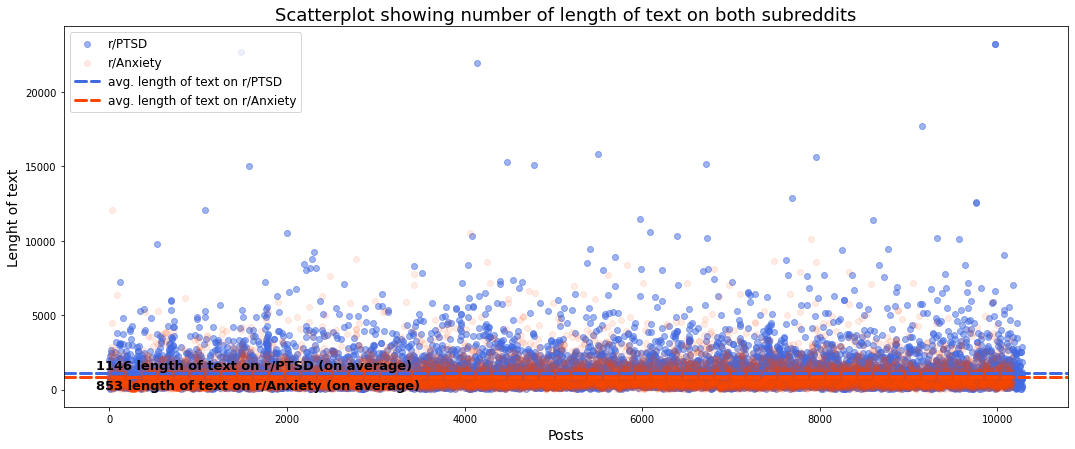

In [ ]:
# Plotting scatterplot to show no. of length of text on both subreddits.

fig, ax = plt.subplots(figsize=(18,7))

plt.scatter(ptsd.index, ptsd['length_text'], color='royalblue', alpha=0.5, label='r/PTSD')
plt.scatter(anxiety.index, anxiety['length_text'], color='orangered', alpha=0.1, label='r/Anxiety')

# Plotting horizontal lines to show average no. of words for posts in both subreddits.
plt.axhline(ptsd['length_text'].mean(),
            label='avg. length of text on r/PTSD',
            ls='--',
            linewidth=3,
            color='royalblue',
            dash_capstyle='round',
           )
plt.figtext(x=0.15,
            y=0.20,
            s=f"{int(round(ptsd['length_text'].mean(), 0))} length of text on r/PTSD (on average)",
            fontsize=13,
            fontweight='semibold'
           )

plt.axhline(anxiety['length_text'].mean(),
            label='avg. length of text on r/Anxiety',
            ls='--',
            linewidth=3,
            color='orangered',
            dash_capstyle='round',
           )
plt.figtext(x=0.15,
            y=0.16,
            s=f"{int(round(anxiety['length_text'].mean(), 0))} length of text on r/Anxiety (on average)",
            fontsize=13,
            fontweight='semibold'
           )


plt.legend(fontsize=12)

plt.xlabel("Posts", fontsize=14)
plt.ylabel("Lenght of text", fontsize=14)

plt.title("Scatterplot showing number of length of text on both subreddits", loc='center', fontsize=18)

Generally the length of text, number of words and even total number of post per users is higher in r/PTSD than in r/Anxiety. 

Specifically, r/PTSD has ave of 4 post compared to r/Anxiety which has ave of 3 post. Considering filtering away one-off users, users in r/PTSD has ave of 8 post compared to r/Anxiety which as ave of 7 post.  

To visualise more, we plot a scatterplot for that shows the average length of text on both subrredicts. On average, the length text for r/PTSD is 1146 while the length of text for r/Anxiety is 853. 

Also we can see majority of the high flyers are coming from users in r/PTSD. This shows that users in r/PTSD are definitely more active in the subreddit, suggesting they might have alot more to share through their experience before getting PTSD. 

As users who might be suffering from PTSD has more specific relation to trauma genericly, people who can relate more to these post, will likely to share their experiences/advice as to how to perhaps overcome such grave issues as compared to having assumingly generic anxiety. 

In [ ]:
# Timespan between creation of latest post scraped and earliest post scraped from r/PTSD.

ptsd_time_diff = ptsd['datetime'].max() - ptsd['datetime'].min()
ptsd_time_diff

Timedelta('337 days 11:18:31')

In [ ]:
# Timespan between creation of latest post scraped and earliest post scraped from r/anxiety.

anxiety_time_diff = anxiety['datetime'].max() - anxiety['datetime'].min()
anxiety_time_diff

Timedelta('45 days 19:20:17')

In [ ]:
# Separating no. of hours and minutes from timespans calculated above.
ptsd_time_diff_h = (ptsd_time_diff.seconds//3600) + (ptsd_time_diff.days * 24)
anxiety_time_diff_h = (anxiety_time_diff.seconds//3600) + (anxiety_time_diff.days * 24)

print(f'r/PTSD has total timespan of {ptsd_time_diff_h} hrs since start of post with 10000 worth of post')
print(f'r/Anxiety has total timespan of {anxiety_time_diff_h} hrs since start of post with 10000 worth of post')

r/PTSD has total timespan of 8099 hrs since start of post with 10000 worth of post
r/Anxiety has total timespan of 1099 hrs since start of post with 10000 worth of post


In [ ]:
ptsd_ave_post_hr = ptsd.shape[0] / ptsd_time_diff_h
anxiety_ave_post_hr = anxiety.shape[0] / anxiety_time_diff_h

print("Average no. of posts created per hour:")
print(f"r/PTSD \t= {round(ptsd_ave_post_hr, 2)}")
print(f"r/Anxiety = {round(anxiety_ave_post_hr, 2)}")
print()

Average no. of posts created per hour:
r/PTSD 	= 1.25
r/Anxiety = 9.25



In [ ]:
# checking shape of unique df
pd.DataFrame(df['author'].unique())

,0
0,cuddlesnakes
1,vampyydemon
2,starlinamidnight
3,josephinabb123
4,BeautifulMind3000
...,...
13612,LuckyJinx98
13613,NewCat24
13614,QuokkaNerd
13615,Ripjaw29


In [ ]:
# create separate data frame to consist of only unique users 
unique_users = pd.DataFrame(df['author'].unique())
# rename columns to pd concat by Author 
unique_users.columns = ['author']
# pd concat with df and remove those that are not within unique_users df 
unique_users = pd.concat([unique_users,df], axis = 1).dropna()

unique_users.shape

NameError: name 'pd' is not defined

In [ ]:
unique_users[unique_users['subreddit'] == 1]

NameError: name 'unique_users' is not defined

NameError: name 'relad_avg_posts' is not defined

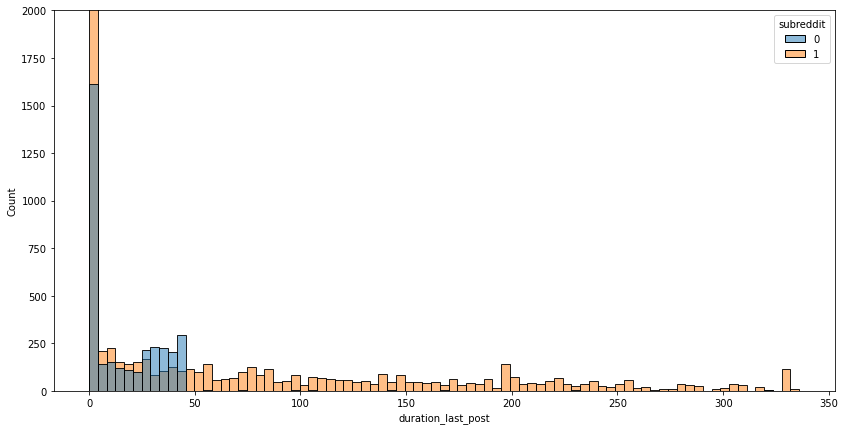

In [ ]:
plt.figure(figsize=(14,7))

sns.histplot(
    x = 'duration_last_post',
    hue = 'subreddit',
    data = unique_users
)

plt.ylim(0,2000)

ptsd_ave_duration = unique_users[unique_users['author'] == 1].mean()

# Plotting horizontal lines to show average no. of posts created per hour.
plt.axvline(unique[], ls='--', color='royalblue')
plt.figtext(x=0.15, y=0.6, s=f"{round(relad_avg_posts, 1)} posts created per hour on r/relationship_advice (on average)", fontsize=12)

In [ ]:
df.groupby(['subreddit'])['duration_last_post'].describe().T

subreddit,0,1
count,10164.000000,10130.000000
mean,8.493900,55.690424
std,20.700363,85.001540
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,2.000000
75%,11.000000,85.000000
max,322.000000,336.000000


In [ ]:
df.groupby(['subreddit'])['duration_last_post'].median()

subreddit
0    0.0
1    2.0
Name: duration_last_post, dtype: float64

On Average, those who are posting more across all users posting reddit, users under PTSD subreddit post 4.88, 1 post more than those who are in Anxiety subreddit. 

Also, excluding those who are active (more than 1 post), users in PTSD subreddit post 1 post more than the other. 

This shows 

In [ ]:
=

SyntaxError: invalid syntax (1763773627.py, line 1)

In [ ]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

# to input in subreddit headers so that we can exclude it for model
headers = ['ptsd', 'anxiety',"cptsd", 'trauma','traumatized','traumas',"posttraumatic",'stress','disorder',"traumatic","'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']
for head in headers:
    stopwordlist.append(head)


# Add additional list from stemmed words 

stemmed_data = ['abov', 'ani', 'anxieti', 'becaus', 'befor', 'disord', 'dure', 'hi', 'onc', 'onli', 'ourselv', 'posttraumat', 'themselv', 'thi', 'traumat', 'veri', 'whi', 'yourselv', 'becau']
for stem in stemmed_data:
    stopwordlist.append(stem)

stopwordlist


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
df.head()

,author,subreddit,selftext,title,created_utc,datetime,alltext,length_text,wrdcount_text,clean_text,ttl_post
0,cuddlesnakes,1,"I'm super mad right now. I've finally managed to call one of the biggest organisations in countries that supports victims of pretty much any crime. \nI've used their online counseling before cause it's easier to write than to talk, and because I was unsure if they even deal with the kind of violence I've experienced. The counselor said they do, and I should contact the local team for in depth cooperation. \n\n\nTurns out, they don't. I've experienced the wrong kind of crime, the wrong kind of violence and there is no support system for me. Their website says that they don't compare or judge between victims of different crimes and support everyone. They fucking need to add a disclaimer with the exceptions. \nThanks for nothing.","""We're helping victims of any crime, but unfortunately you've experienced the wrong kind of crime""",1648127141,2022-03-24 13:05:41,"I'm super mad right now. I've finally managed to call one of the biggest organisations in countries that supports victims of pretty much any crime. \nI've used their online counseling before cause it's easier to write than to talk, and because I was unsure if they even deal with the kind of violence I've experienced. The counselor said they do, and I should contact the local team for in depth cooperation. \n\n\nTurns out, they don't. I've experienced the wrong kind of crime, the wrong kind of violence and there is no support system for me. Their website says that they don't compare or judge between victims of different crimes and support everyone. They fucking need to add a disclaimer with the exceptions. \nThanks for nothing. ""We're helping victims of any crime, but unfortunately you've experienced the wrong kind of crime""",830,140,im super mad right ive finally managed call one biggest organisations countries supports victims pretty much crime ive used online counseling cause easier write talk unsure even deal kind violence ive experienced counselor said contact local team depth cooperation turns dont ive experienced wrong kind crime wrong kind violence support system website says dont compare judge victims different crimes support everyone fucking add disclaimer exceptions thanks nothing helping victims crime unfortunately youve experienced wrong kind crime,1
1,vampyydemon,1,"I honestly feel like I'm losing myself. I don't know what to do. Ever since I found out my boyfriend had cheated on me over a hundred times and tried to convince me that I was in the wrong, I believe I may have developed PTSD as a result.\n\nEver since I found out a year ago, I've been having nightmares, flashbacks, intrusive thoughts/memories, feeling on edge all the time, the obvious symptoms. But something that has really got me concerned is this sudden onset of dissociative amnesia.\n\nI've forgotten most of the infidelity that happened, and the extreme emotional pain it caused me. I don't wanna remember that shit anyway. But I'm also forgetting things just minutes after they happen, I've forgotten about certain people/places/events, and hell, I don't even remember who I am or what my interests are and what I stand for anymore. I've forgotten so much shit that I don't want to forget. It's impacted my functioning a great deal, and it's really concerning me a lot.\n\nNow I have C-PTSD from being abused and neglected by my parents repeatedly as a child, so the memory loss thing isn't new to me. I barely remember anything from my childhood. But the fact that this sudden memory loss has happened so quickly and is this severe has really taken me back quite a lot. I never expected it to be this bad.\n\nI also have Borderline Personality Disorder, so I do have times where I'll have issues with my identity and with not really knowing who I am. But I've never just straight up completely forgotten who I am, what my interests are, what my core values are, etc. Usually my identit

In [ ]:
X = df['selftext']
y = df['subreddit']

#  Train test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwordlist)    


In [ ]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
clf = MultinomialNB(alpha=1.0)
clf.fit(X_train, y_train)

MultinomialNB()

In [ ]:
df['subreddit'].value_counts(normalize= True)

0    1.0
Name: subreddit, dtype: float64

In [ ]:
clf.predict(X_train)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
vectorizer.get_feature_names()[0]

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'00'

In [ ]:
# Test the prediction
# for first row, seeing prob of getting PTSD given using the word for 00 is higher than of given not PTSD
clf.predict_proba(X_train[0, :])


array([[1.]])

In [ ]:
df.shape

(20294, 11)

In [ ]:
# need to do todense() because after we vectorise, it is in a sparse matrix
# hence in order to read, we do todense

X_train.todense().shape

(13596, 28558)

In [ ]:
# two rows of probabilities 
# first is for 0 (NOT PTSD)
# second is for 1 (PTSD)

clf.feature_log_prob_.shape

(1, 28558)

In [ ]:
print(f'Log prob given not PTSD: {clf.feature_log_prob_[1, :]}') 

print(f'Log prob given PTSD: {clf.feature_log_prob_[0, :]}') 

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
delta = clf.feature_log_prob_[1, :] - clf.feature_log_prob_[0, :]


df_multinomial = pd.DataFrame([[x,y] for x,y in zip(vectorizer.get_feature_names(),delta)])
df_multinomial.rename(columns= {0: 'Features', 1: 'log_prob_diff'}, inplace = True)
df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).head(20)

,Features,log_prob_diff
10340,flashbacks,3.671784
10338,flashback,3.394755
20389,raped,3.251154
20387,rape,3.243639
1116,abuser,3.173942
2492,assault,3.074608
1115,abused,2.947430
2493,assaulted,2.771845
1114,abuse,2.669279
17140,nightmares,2.541429


In [ ]:
X = df['selftext']
y = df['subreddit']

class LemmaTokenizer(object):
    def __init__(self):
        self.stem = PorterStemmer()
    def __call__(self,articles):
        return [self.stem.stem(t) for t in word_tokenize(articles)]


#  Train test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe = Pipeline([
    ('cvec', TfidfVectorizer(stop_words = stopwordlist, tokenizer= LemmaTokenizer())),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [1_000],
    'cvec__min_df': [.002],
    'cvec__max_df': [.6],
    'cvec__ngram_range': [(1,1), (1,2)],
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation

gs.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
gs.best_estimator_


Pipeline(steps=[('cvec',
                 TfidfVectorizer(max_df=0.6, max_features=1000, min_df=0.002,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<__main__.LemmaTokenizer object at 0x00000298490EB970>)),
                ('nb', MultinomialNB())])

In [ ]:
# What's the best score?
print('Best score:', gs.best_score_)

# Score model on training set.
print('Best training score:', gs.score(X_train, y_train))
  
# Score model on testing set.
print('Best test score:', gs.score(X_test, y_test))

Best score: 0.7998381487571122
Best training score: 0.8080005882785499
Best test score: 0.8087774294670846


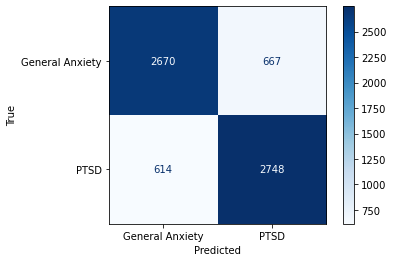

In [ ]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix
cmd = plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['General Anxiety','PTSD'])
cmd.ax_.set(xlabel='Predicted', ylabel='True');

In [ ]:
# to create delta between the log probabilities between two classes
delta = gs.best_estimator_[1].feature_log_prob_[1, :] - gs.best_estimator_[1].feature_log_prob_[0, :]

# Create Df and filter top few log prob 
df_multinomial = pd.DataFrame([[x,y] for x,y in zip(gs.best_estimator_[0].get_feature_names(), np.exp(delta))])
df_multinomial.rename(columns= {0: 'Features', 1: 'Probability_PTSD'}, inplace = True)
df_multinomial.sort_values(by = 'Probability_PTSD', ascending = False).head(30)


,Features,Probability_PTSD
356,flashback,57.169785
706,rape,55.580035
103,assault,29.973813
42,abus,14.869021
293,emdr,11.873103
778,sexual,10.409478
608,nightmar,8.225898
937,victim,7.568245
260,dissoci,6.386084
562,memori,6.039942


In [ ]:
def lemmetize_print(words):
     from nltk.stem import WordNetLemmatizer
     from nltk.tokenize import word_tokenize
     lemmatizer = WordNetLemmatizer()
     a = []
     tokens = word_tokenize(words)
     for token in tokens:
          if token in ['abused']:
              a.append('abuse')
          lemmetized_word = lemmatizer.lemmatize(token)
          a.append(lemmetized_word)
     sentence = " ".join(a)
     print(sentence)



text = 'flashbacks flashback abused'

lemmetize_print(text)

flashback flashback abuse abused


In [ ]:
stemmer = PorterStemmer()


def lemmetize_print(words):
     stemmer = PorterStemmer()
     a = []
     tokens = word_tokenize(words)
     for token in tokens:
          lemmetized_word = stemmer.stem(token)
          a.append(lemmetized_word)
     sentence = " ".join(a)
     print(sentence)


text = 'flashbacks flashback abuser'

lemmetize_print(text)

flashback flashback abus
